In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import DataCollection as dc
from numpy.polynomial import hermite
import time

In [2]:
#Specify ROI
ROI = [[-1.5, 1.5]] # Need double lists
#Define eta and the function f for a 1d system.
eta = lambda x: np.abs(x) #np.power(np.abs(x),1.5) #np.power(x, 2)

def ode_function(t, var):
    x, I = var
    return [-x + np.power(x,3), eta(x)]


In [3]:
t_span = [0, 1]
span = 1 #Terminate Time
time_discretization = 1000

## 1. Generate training data
### 1.1 Generate samples and trajectories

In [4]:
#The scipy.integrate tool for solving IVP may not return the full array with the specified length. 
#Define a function to fulfill the solution array. 
def fullarr(arr, N):
    if arr.shape[0]<N:
        d = N - arr.shape[0]
        # Create an array of length d filled with the last element of n_dim_array
        append_array = np.full((d,), arr[-1])
        # Concatenate n_dim_array with append_array to create an m-dimensional row array
        long_arr = np.concatenate((arr, append_array))
        return long_arr
    else:
        return arr

In [5]:
M = 3001  #Sample size
sample = np.random.uniform(-1.5, 1.5, M) #np.linspace(-1.5,1.5,M) #np.random.uniform(-1.5, 1.5, M)

In [6]:
#Initialize the flow map and the integral
phi = np.zeros(M)
I = np.zeros(M)

ODE solving & modification time = 15.980654001235962 sec


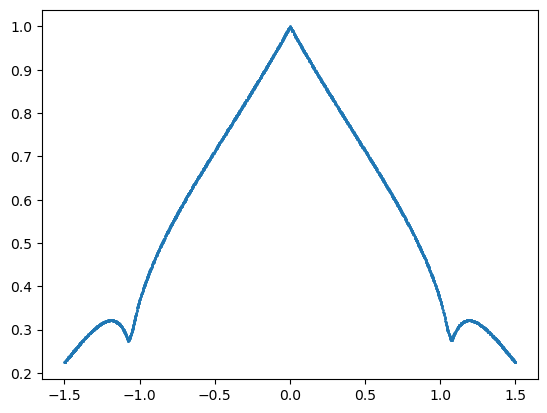

In [7]:
t_span = [0, 10]
span = 1 #Terminate Time
NN = 1000
tic1 = time.time()
for i in range(M):
    y0 = [sample[i], 0]
    soln = solve_ivp(ode_function, t_span, y0, t_eval=np.linspace(0, span, NN))
    data = soln.y[0]
    integral = soln.y[1]
    index = dc.id_out(data, ROI)
    if index:
        mod_data, intersect = dc.data_mod(data, index, ROI)
        mod_integral_data = dc.integral_mod(integral, mod_data, index, eta, span)
    else:
        mod_data = data
        mod_integral_data = integral
    phi[i] = mod_data[-1]
    I[i] = mod_integral_data[-1]
print('ODE solving & modification time = {} sec'.format(time.time()-tic1))
exp = np.exp(-I)
plt.scatter(sample, exp, s=1) #plt.plot(sample, exp)

### 1.2 Introduce function dictionary and generate training data

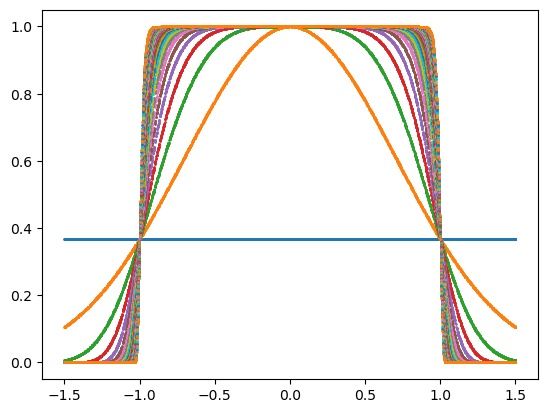

In [9]:
def fac(n):
    if n < 0:
        return "Input must be a non-negative integer"
    result = 1
    for i in range(1, n+1):
        result *= i
    return result

def herm(N, n, x):
    C = np.eye(N)
    return np.exp(-np.power(hermite.hermval(x, C[n]), 2))* np.exp(-np.power(x, 2)/2) 

def gauss(n, x):
    return np.exp(-n *  np.square(x))

def inv_quad(n, x):
    return 1/(1+n*np.square(x))
    
def poly(n, x):
    return np.exp(-np.power(x, 2*n))

def cosr(n, x):
    return np.cos(2*np.pi*n*x/3) 

def expi(n, x):
    return np.exp(1j * 2*np.pi*n*x/3 )

def exp_p(n, x):
    return np.power(np.exp(1j * 2*np.pi*n*x/3 ), 2)

def d_expi(n, x):
    return 1j * (2*np.pi*n/3) * np.exp(1j * 2*np.pi*n*x)

def exp_g(n, x):
    return np.cos(2*np.pi*n*x/3) * np.exp(-np.power(x, 2)/4)

def exp_tanh(n, x):
    return np.cos(2*np.pi*n*x/3) * np.exp(-np.power(x, 2)/2)


# Example usage:

for i in range(0,32):
    plt.scatter(sample, poly(i, sample), s=1) #plt.plot(sample, exp_g(i, sample))
    


In [191]:
threshold = 1e-10
N = 512

In [193]:
#Generate stacking data
tic=time.time()
X = (np.array([exp_g(i, sample) for i in range(-(N-1), N)])).T
Y = np.array([exp_g(i, phi)*exp for i in range(-(N-1), N)]).T
#X[np.abs(X) < threshold] = 0
print('Stacking time = {} sec'.format(time.time()-tic))

Stacking time = 0.5493738651275635 sec


## 2. Operator Learning

In [194]:
tic=time.time()
pinv = np.linalg.pinv((X.T)@ X)
T = (pinv @ ((X.T) @ Y))
threshold = 1e-8
#T[np.abs(T) < threshold] = 0
print('Operator learning time = {} sec'.format(time.time()-tic))

Operator learning time = 0.5317351818084717 sec


In [195]:
#Checking eigens
e, v = np.linalg.eig(T)
print(e)

[ 9.99471706e-01+0.00000000e+00j  3.32852179e-01+1.08836995e-01j
  3.32852179e-01-1.08836995e-01j ... -9.44913252e-18-3.27634938e-18j
  3.35380775e-18+0.00000000e+00j -7.61119206e-18+0.00000000e+00j]


In [196]:
ln_e = np.log(e)
real_parts = ln_e.real
imaginary_parts = ln_e.imag

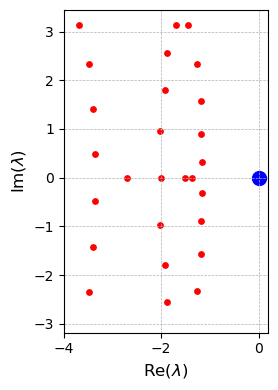

In [173]:
# Create the plot for the eigenvalues
fig, ax = plt.subplots(figsize=(5, 4))

check_num = 200
# Scatter plot
ax.scatter(real_parts[0], imaginary_parts[0], color='blue', s=100)
ax.scatter(real_parts[1:check_num], imaginary_parts[1:check_num], color='red', s=15)  # s is size of the dots

# Set axis labels
ax.set_xlabel('Re($\lambda$)', fontsize=12)
ax.set_ylabel('Im($\lambda$)', fontsize=12)
ax.set_xlim(-4, 0.2)
#ax.set_yticks(range(-3, 3))
#ax.set_title('(e)', loc='left')

# Display the grid
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# Set the aspect ratio of the plot to be equal
ax.set_aspect('equal', 'box')

plt.tight_layout()
plt.show()
fig.savefig('eig_val', dpi=300)

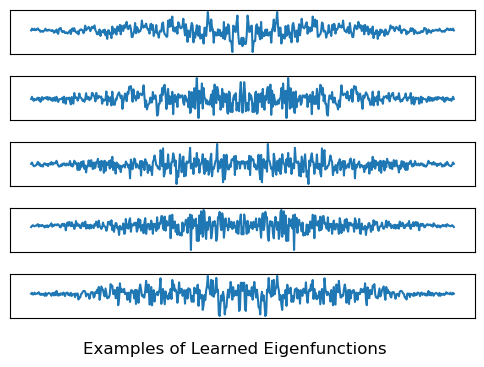

In [197]:
#Show eigenfunctions
fig, axs = plt.subplots(5, 1, sharex=True, figsize=(6, 4))
x_samp_eigplot=np.linspace(-1.5, 1.5, 501)
X_eigplot = (np.array([exp_g(i, x_samp_eigplot) for i in range(-(N-1), N)])).T
eig_func0 = X_eigplot @  v[0]
eig_func1 = X_eigplot @  v[1]
eig_func2 = X_eigplot @  v[2]
eig_func3 = X_eigplot @  v[3]
eig_func4 = X_eigplot @  v[4]
# Adjust the height of each subplot
fig.subplots_adjust(hspace=0.5)  # Adjust this value to change the spacing between plots

# Plot each function on its respective subplot
axs[0].plot(x_samp_eigplot, eig_func0)
axs[0].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

axs[1].plot(x_samp_eigplot, eig_func1)
axs[1].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

axs[2].plot(x_samp_eigplot, eig_func2)
axs[2].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

axs[3].plot(x_samp_eigplot, eig_func3)
axs[3].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

axs[4].plot(x_samp_eigplot, eig_func4)
axs[4].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)

fig.suptitle('Examples of Learned Eigenfunctions', y=0.05)

fig.savefig('eig_func', dpi=300)
plt.show()

## 3. Function U approximation

In [198]:
def matrix_iteration(A, n):
    """
    Multiplies matrix A by itself n times.

    Parameters:
    A (numpy.ndarray): Input matrix
    n (int): Number of times to multiply the matrix by itself

    Returns:
    numpy.ndarray: Resultant matrix
    """
    if n <= 0:
        return np.eye(A.shape[0])  # Return identity matrix for n <= 0
    result = np.copy(A)
    for _ in range(n - 1):
        result = np.dot(result, A)
    return result


In [199]:
#Finding the weight for the observable exp(-x^2/2)
a = np.zeros(N*2-1) 
a[N]=1

In [200]:
k = 10
#TX = (T @ X)/np.max((T @ X))
Tk = matrix_iteration(T, k)
vec = Tk @ a
#final = X @ vec

### Create intermediate  steps of iteration

In [201]:
T2 = matrix_iteration(T, 1)
vec2 = T2 @ a
T4 = matrix_iteration(T, 2)
vec4 = T4 @ a

In [202]:
T6 = matrix_iteration(T, 3)
vec6 = T6 @ a

In [203]:
T8 = matrix_iteration(T, 4)
vec8 = T8 @ a

In [204]:
T9 = matrix_iteration(T, 9)
np.linalg.norm(Tk-Tk@Tk, ord='fro')

0.08909123012450755

In [205]:
#Plotting the evolution
sam_new = np.linspace(-1.5, 1.5, 12001)
h_test = (np.array([exp_g(i, sam_new) for i in range(-(N-1), N)])).T
U_test = h_test @ vec

In [206]:
U2 = h_test @ vec2
U4 = h_test @ vec4
U6 = h_test @ vec6
U8 = h_test @ vec8
U0 = exp_g(0, sam_new)

In [210]:
# Create a gradient of colors
num_colors = 20
colors = plt.cm.jet(np.linspace(0.2, 1, num_colors))

# Generate some sample data
x = np.linspace(0, 10, num_colors)
y = np.log(x + 1)

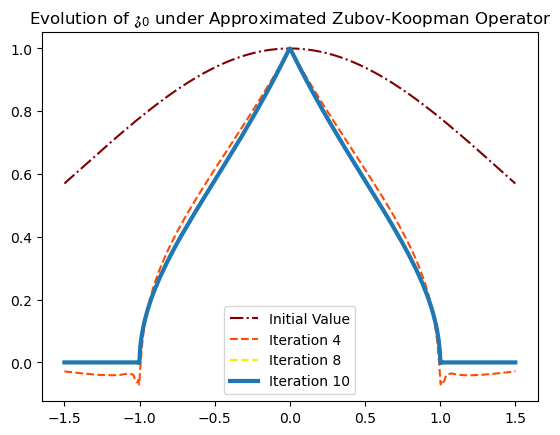

In [211]:
largest_value = np.max(np.abs(U_test))
ind_l = np.argmax(U_test)
U_test = U_test/U_test[ind_l]
U_test = np.real(U_test)
plt.plot(sam_new, U0, '-.', color=colors[19], label='Initial Value')
plt.plot(sam_new, U4, '--', color=colors[15], label='Iteration 4')
plt.plot(sam_new, U8, '--', color=colors[11], label='Iteration 8')
plt.plot(sam_new, U_test,  linewidth=3, label='Iteration 10')
plt.title('Evolution of $\mathfrak{z}_0$ under Approximated Zubov-Koopman Operator')
plt.legend()
plt.savefig('evolution.png', dpi=300) 

## 4. Compare Results

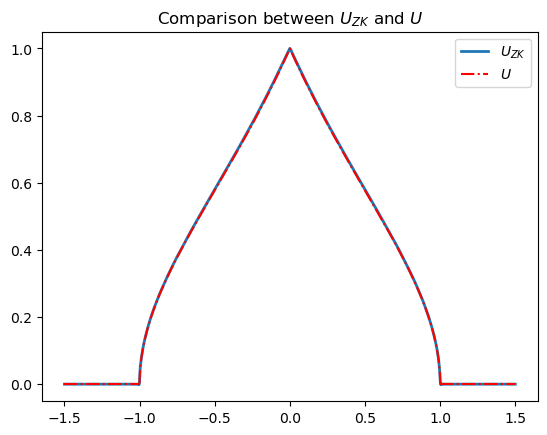

In [213]:
def U_real(x):
    return  np.exp(-(np.log(1+eta(x))-np.log(1-eta(x)))/2) 

def zero(x):
    return np.zeros(x.shape)

sam1 = np.linspace(-0.99999, 0.99999,6000)
sam2 = np.linspace(-1.5, -1)
sam3 = np.linspace(1, 1.5)

plt.plot(sam_new, U_test, label='$U_{ZK}$',  linewidth=2)
plt.plot(sam1, U_real(sam1), '-.', color='r', label='$U$' )
plt.plot(sam2, zero(sam2), '-.', color='r')
plt.plot(sam3, zero(sam3), '-.', color='r')
plt.title('Comparison between $U_{ZK}$ and $U$')
plt.legend()
plt.savefig('1d_U.png', dpi=300) 

In [214]:
def d_expi(n, x):
    return 1j * (2*np.pi*n/3) * np.exp(1j * 2*np.pi*n*x)

def d_expg(n, x):
    return -np.exp(-np.power(x, 2)/4) /2 * (4*np.pi*n/3 * np.sin(2*np.pi*n/3*x) + x * np.cos(2*np.pi*n/3 * x))


indices = np.where(final > 0.0011)
U = final[indices]

V = -np.log(U)
dU = (np.array([d_expg(i, sample[indices]) for i in range(-N+1, N)])).T @ vec
f_x, _ = ode_function(1, [sample[indices], 0])
U_real = np.exp(-(np.log(1+eta(sample[indices]))-np.log(1-eta(sample[indices])))/2) # np.sqrt(1- eta(sample[indices]))

/var/folders/kh/ly61z1b53rn2l92lz5cfcmx00000gn/T/ipykernel_8115/2233105140.py:14: RuntimeWarning: invalid value encountered in log
  U_real = np.exp(-(np.log(1+eta(sample[indices]))-np.log(1-eta(sample[indices])))/2) # np.sqrt(1- eta(sample[indices]))


In [215]:
indices = np.where(U_test > 0.05)
U_roa = U_test[indices]

V = -np.log(U_roa)
dU_roa = np.real((np.array([d_expg(i, sam_new[indices]) for i in range(-N+1, N)])).T @ vec)
f_x, _ = ode_function(1, [sam_new[indices], 0])

In [222]:
sam_new[indices]

array([-0.99525, -0.995  , -0.99475, ...,  0.99475,  0.995  ,  0.99525])

In [223]:
np.max(U_test[indices] - np.sqrt(1- eta(sam_new[indices])))

0.000300044952188383

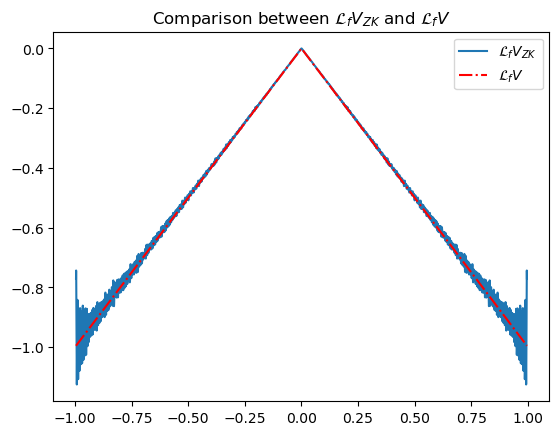

In [224]:
plt.plot(sam_new[indices], -dU_roa/U_roa* f_x, label='$\mathcal{L}_fV_{ZK}$')
plt.plot(sam_new[indices], -eta(sam_new[indices]), '-.', color='r', label='$\mathcal{L}_fV$')
plt.title('Comparison between $\mathcal{L}_fV_{ZK}$ and $\mathcal{L}_fV$')
plt.legend()
plt.savefig('LfV.png', dpi=300) 

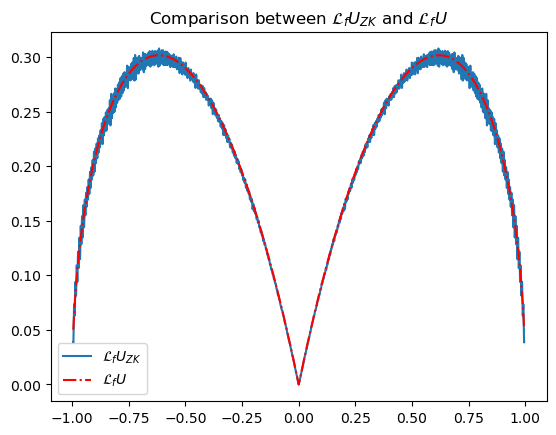

In [225]:
plt.plot(sam_new[indices], dU_roa* f_x, label='$\mathcal{L}_fU_{ZK}$')
plt.plot(sam_new[indices], eta(sam_new[indices])*U_roa, '-.', color='r', label='$\mathcal{L}_fU$')
plt.title('Comparison between $\mathcal{L}_fU_{ZK}$ and $\mathcal{L}_fU$')
plt.legend()
plt.savefig('LfU.png', dpi=300) 

In [226]:
indices_neg = np.where(-dU_roa/U_roa* f_x >0.)
indices_neg

(array([], dtype=int64),)

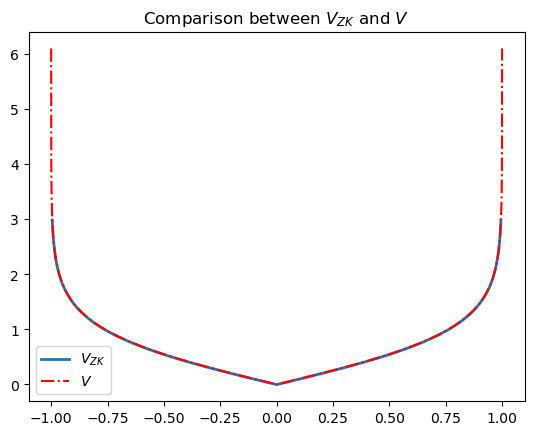

In [227]:
plt.plot(sam_new[indices], V, label='$V_{ZK}$',  linewidth=2)
plt.plot(sam1, -np.log(np.sqrt((1-eta(sam1))/(1+eta(sam1)))), '-.', color='r', label='$V$' )
plt.title('Comparison between $V_{ZK}$ and $V$')
plt.legend()
plt.savefig('1d_V.png', dpi=300) 


#plt.plot(sam_new[indices], V, label='V approx')
#plt.plot(sam_new[indices], -np.log(np.sqrt((1-eta(sam_new[indices]))/(1+eta(sam_new[indices])))), label='V real')
#plt.legend()